**Loading data from csv**


In [78]:
import pandas as pd

In [79]:
sp500 = pd.read_csv('GSPC.csv',na_values=['null'],na_filter=True).set_index('Date')
dax = pd.read_csv('GDAXI.csv',na_values=['null'],na_filter=True).set_index('Date')
nikkei225 = pd.read_csv('N225.csv',na_values=['null'],na_filter=True).set_index('Date')

** Preprocessing data **

In [80]:
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
closed_data = pd.DataFrame()
closed_data['sp_closed'] = sp500['Adj Close']
closed_data['dax_closed'] = dax['Adj Close']
closed_data['n225_closed'] = nikkei225['Adj Close']
closed_data = closed_data.fillna(method='ffill').dropna()

In [82]:
#closed_data.describe()
closed_data.head()

,sp_closed,dax_closed,n225_closed
Date,,,
2007-01-04,1418.339966,6674.399902,17353.669922
2007-01-05,1409.709961,6593.089844,17091.589844
2007-01-08,1412.839966,6607.589844,17091.589844
2007-01-09,1412.109985,6614.370117,17237.769531
2007-01-10,1414.849976,6566.560059,16942.400391


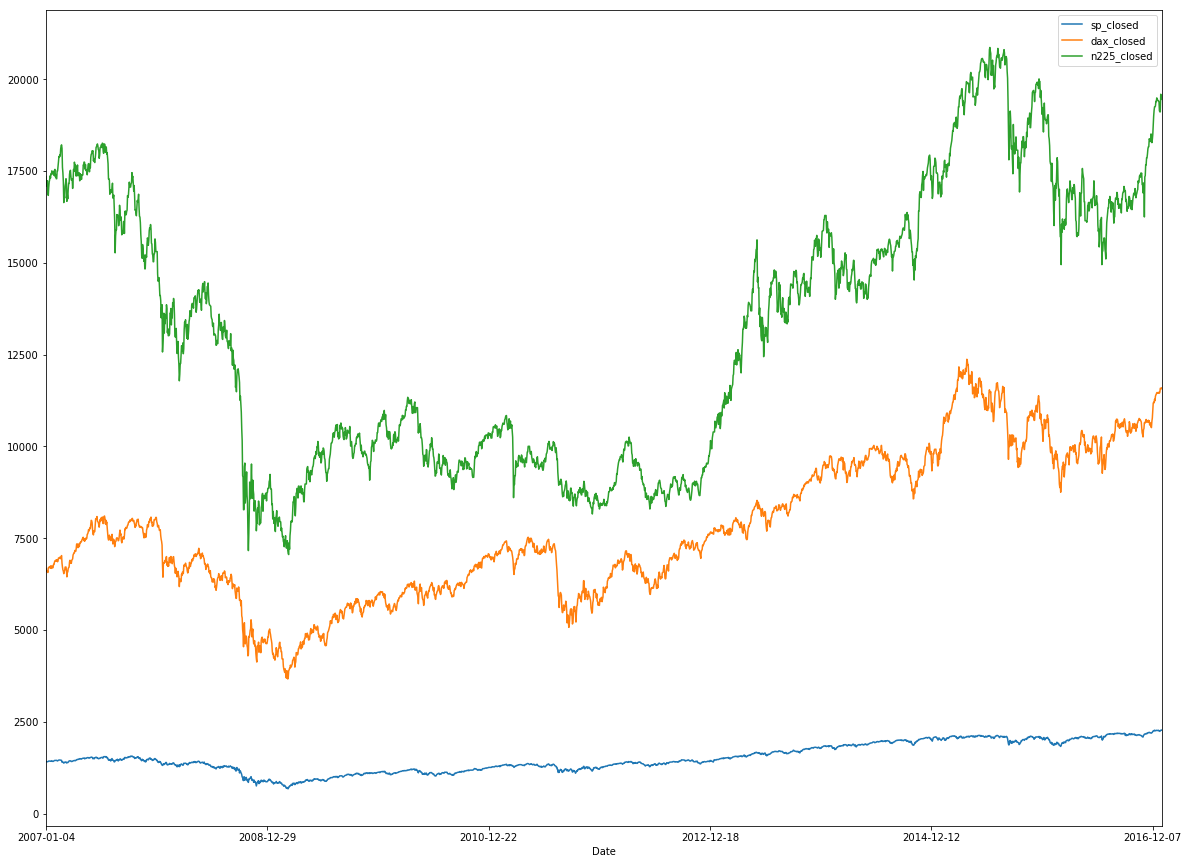

In [83]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.
_ = pd.concat([closed_data['sp_closed'],closed_data['dax_closed'],closed_data['n225_closed']], 
              axis=1).plot(figsize=(20, 15))

In [84]:
closed_data['sp_closed_scaled'] = closed_data['sp_closed']/max(closed_data['sp_closed'])
closed_data['dax_closed_scaled'] = closed_data['dax_closed']/max(closed_data['dax_closed'])
closed_data['n225_closed_scaled'] = closed_data['n225_closed']/max(closed_data['n225_closed'])

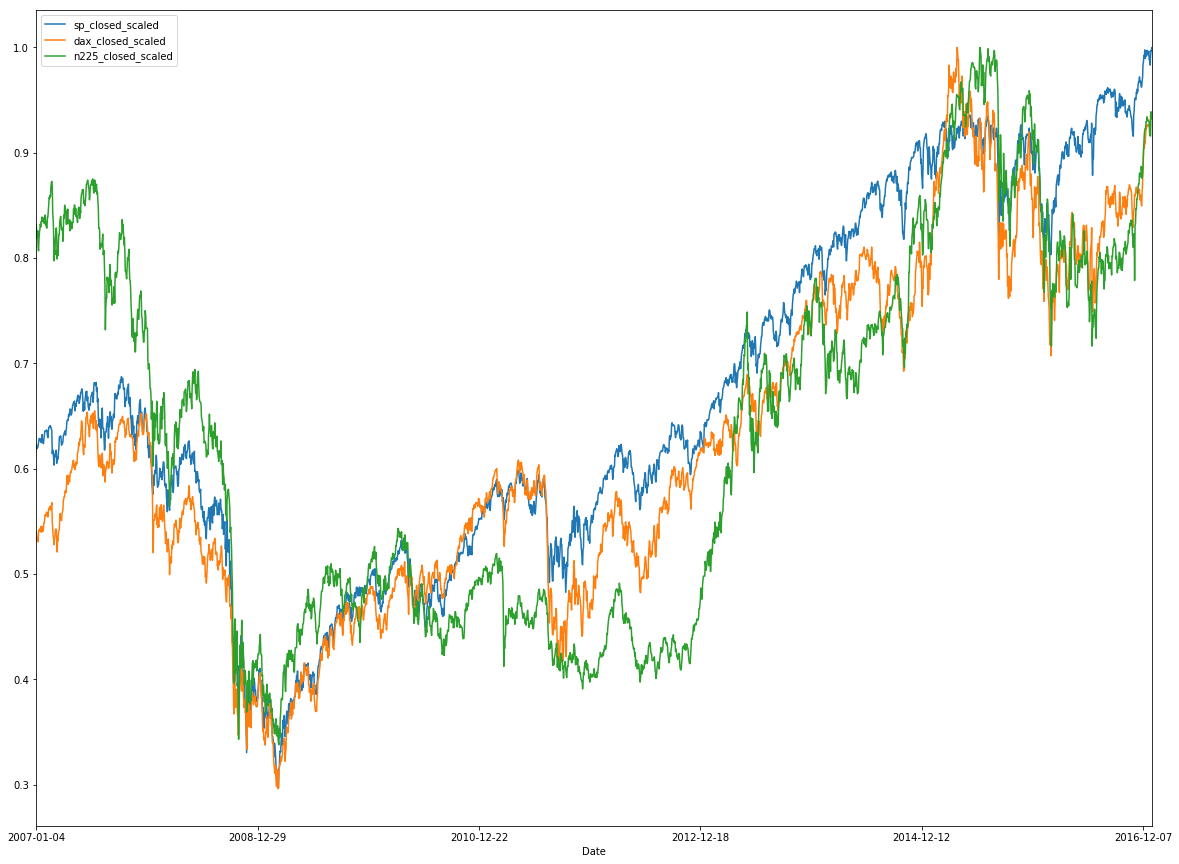

In [85]:
_ = pd.concat([closed_data['sp_closed_scaled'],closed_data['dax_closed_scaled'],closed_data['n225_closed_scaled']], 
              axis=1).plot(figsize=(20, 15))

** Autocorrelation Plot **

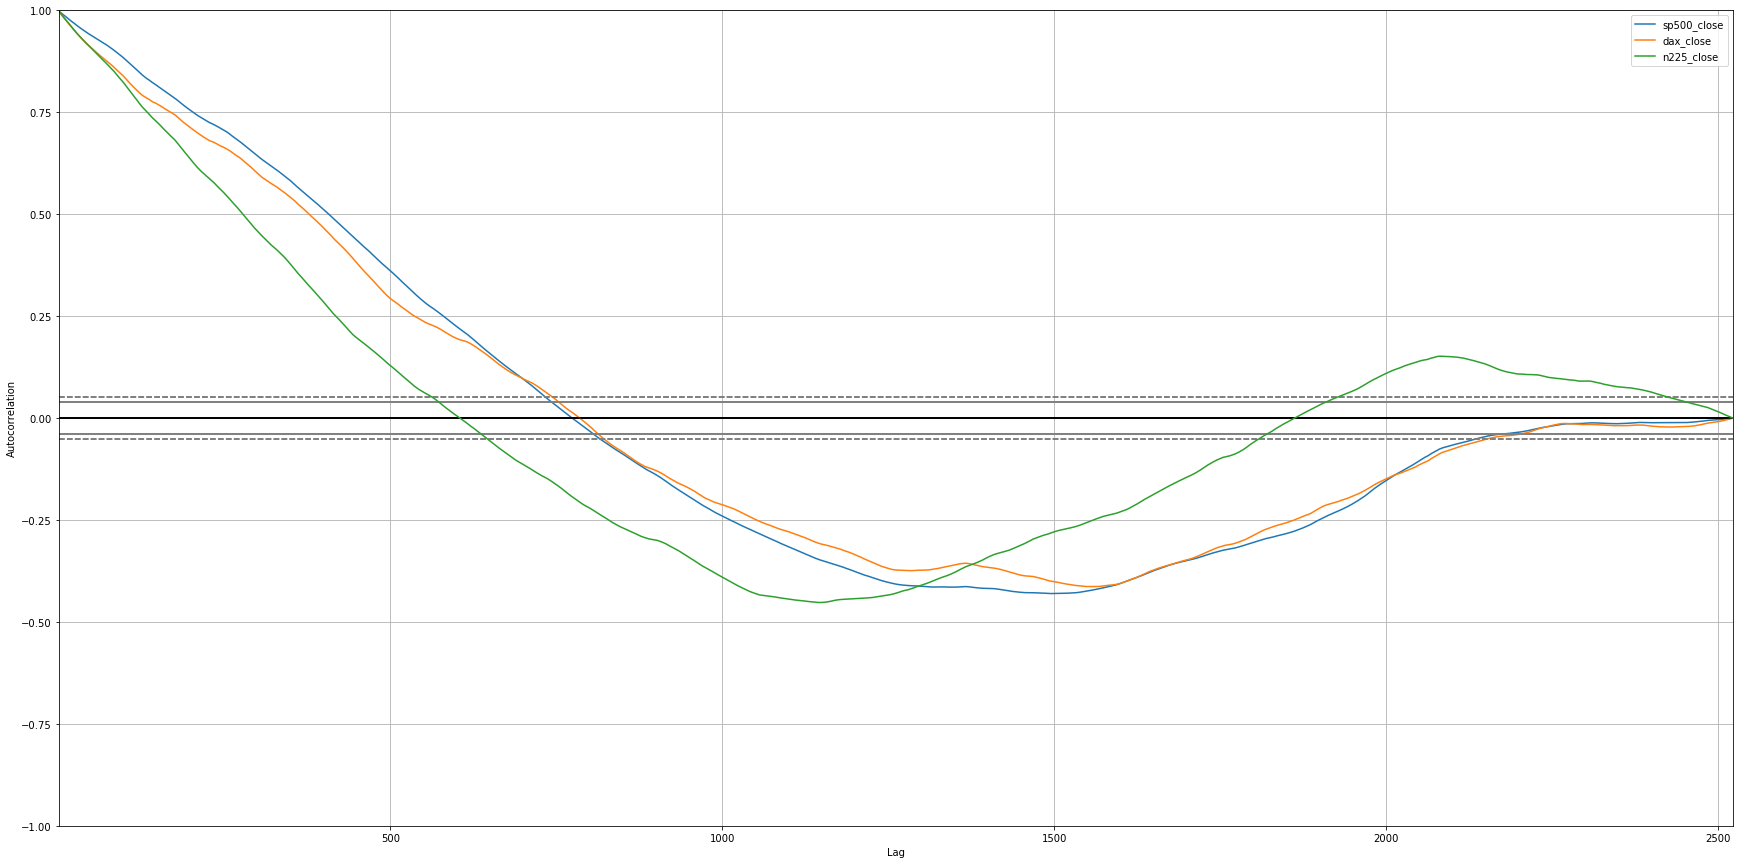

In [86]:
fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(15)
_ = autocorrelation_plot(closed_data['sp_closed'], label='sp500_close')
_ = autocorrelation_plot(closed_data['dax_closed'], label='dax_close')
_ = autocorrelation_plot(closed_data['n225_closed'], label='n225_close')
_ = plt.legend(loc='upper right')

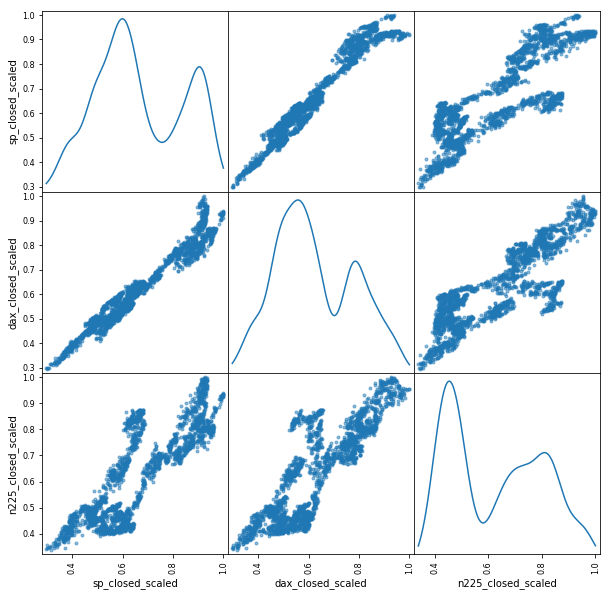

In [87]:
_ = scatter_matrix(pd.concat([closed_data['sp_closed_scaled'],
  closed_data['dax_closed_scaled'],
  closed_data['n225_closed_scaled']
  ], axis=1), figsize=(10, 10), diagonal='kde')

** Data Transform **

In [88]:
log_return = pd.DataFrame()
log_return['sp'] = np.log(closed_data['sp_closed']/closed_data['sp_closed'].shift())
log_return['dax'] = np.log(closed_data['dax_closed']/closed_data['dax_closed'].shift())
log_return['n225'] = np.log(closed_data['n225_closed']/closed_data['n225_closed'].shift())
#log_return = log_return.dropna()
#log_return.describe()
log_return.head()

,sp,dax,n225
Date,,,
2007-01-04,NaN,NaN,NaN
2007-01-05,-0.006103,-0.012257,-0.015217
2007-01-08,0.002218,0.002197,0.000000
2007-01-09,-0.000517,0.001026,0.008516
2007-01-10,0.001938,-0.007254,-0.017284


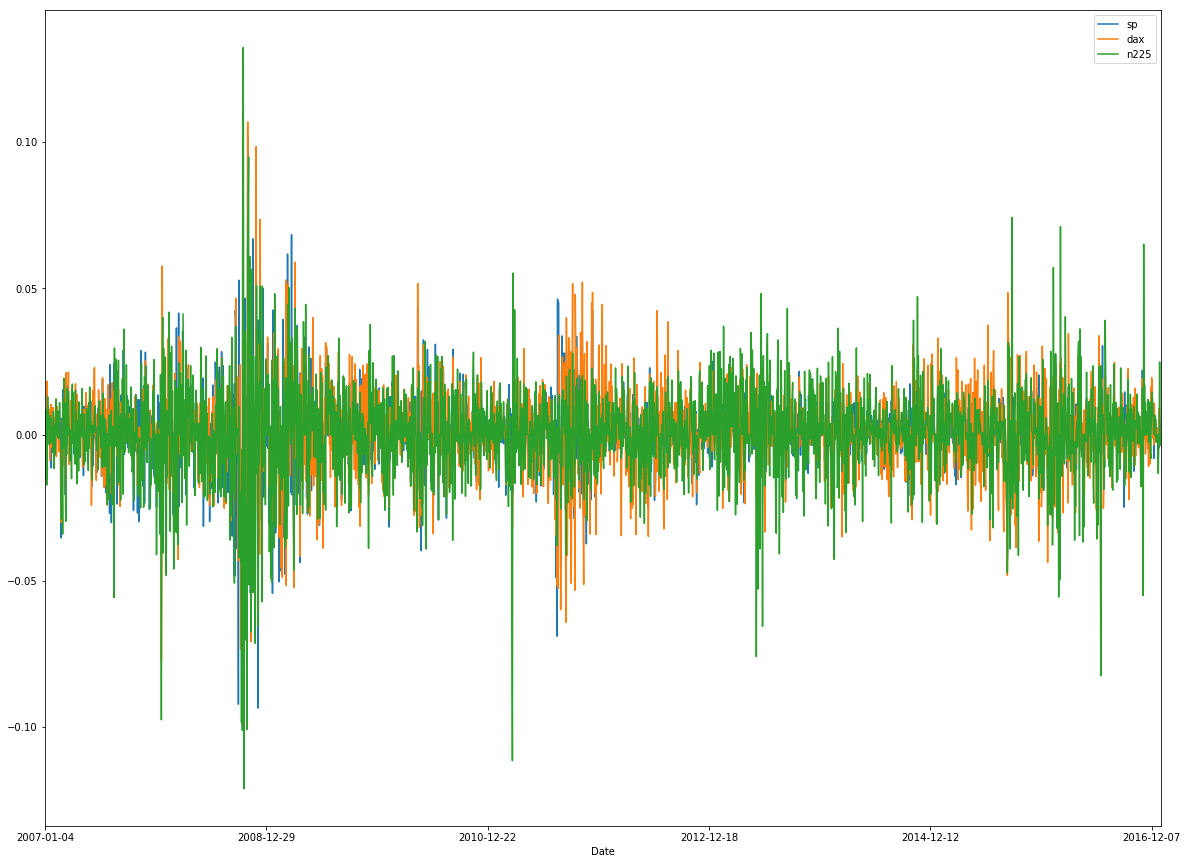

In [89]:
_ = pd.concat([log_return['sp'],log_return['dax'],log_return['n225']],axis=1).plot(figsize=(20,15))

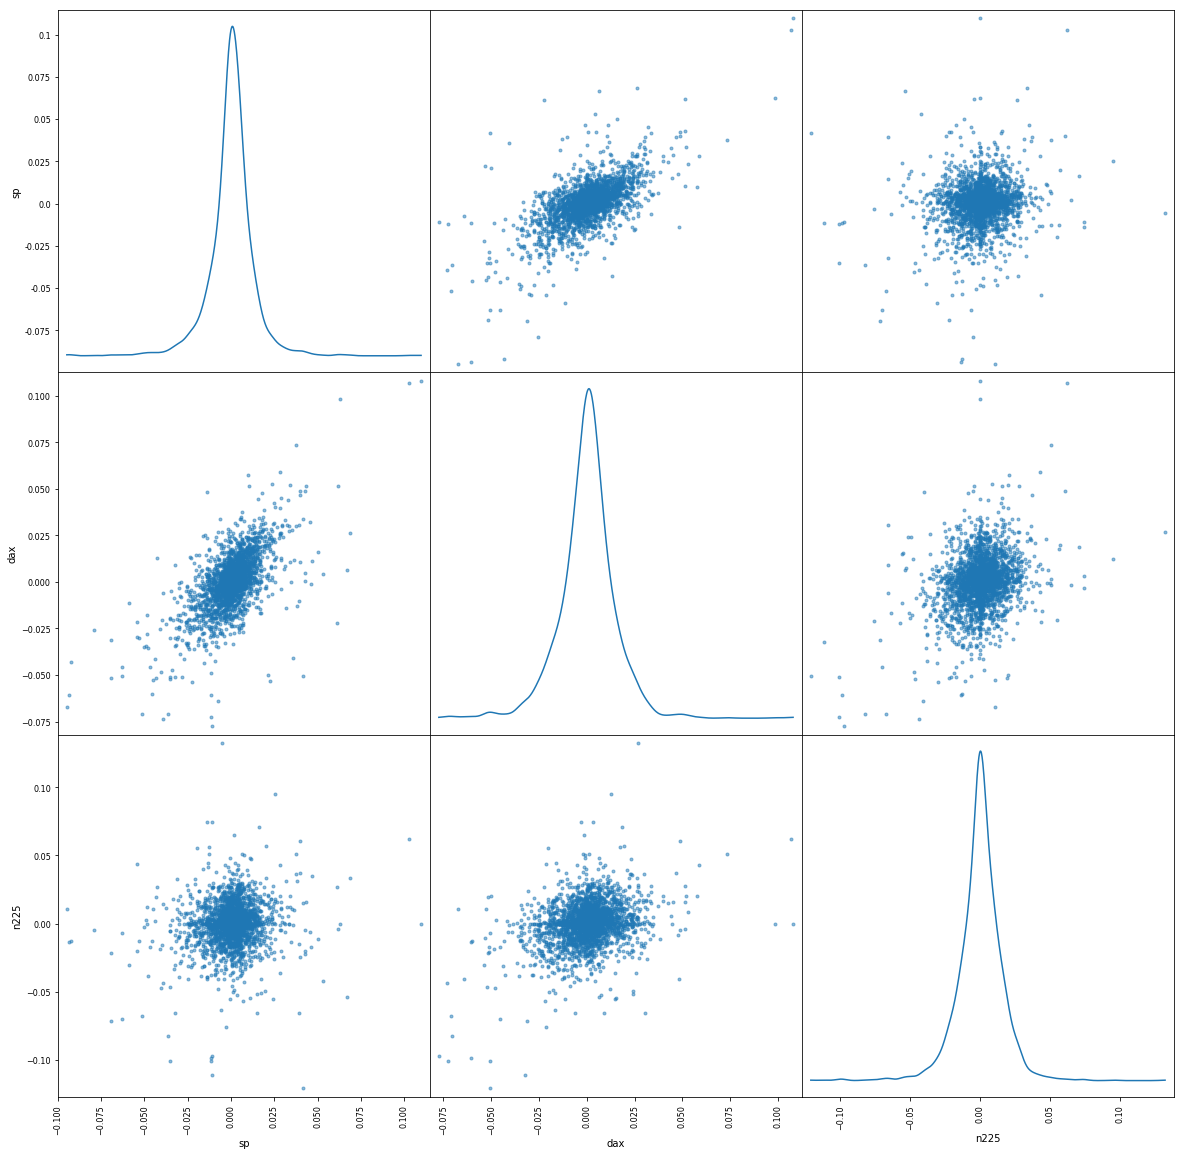

In [90]:
_ = scatter_matrix(log_return, figsize=(20, 20), diagonal='kde')

** Set-up Train test dataset **

In [91]:
# set label to 1 if sp greater than 0 otherwise to 0
log_return['sp_postive'] = log_return['sp'].apply(lambda x: 1 if x>0 else 0)
log_return['sp_negative'] = log_return['sp'].apply(lambda x: 1 if x<0 else 0)
log_return.head()
#log_return.tail()

,sp,dax,n225,sp_postive,sp_negative
Date,,,,,
2007-01-04,NaN,NaN,NaN,0,0
2007-01-05,-0.006103,-0.012257,-0.015217,0,1
2007-01-08,0.002218,0.002197,0.000000,1,0
2007-01-09,-0.000517,0.001026,0.008516,0,1
2007-01-10,0.001938,-0.007254,-0.017284,1,0


In [92]:
training_test_data = pd.DataFrame(
    columns = ['sp_positive','sp_1','sp_2','dax_0','dax_1','dax_2','n225_0','n225_1','n225_2']
)

for i in range(3,len(log_return)):
    sp_positive = log_return['sp_postive'].iloc[i]
    sp_1 = log_return['sp'].iloc[i-1]
    sp_2 = log_return['sp'].iloc[i-2]
    dax_0 = log_return['dax'].iloc[i]
    dax_1 = log_return['dax'].iloc[i-1]
    dax_2 = log_return['dax'].iloc[i-2]
    n225_0 = log_return['n225'].iloc[i]
    n225_1 = log_return['n225'].iloc[i-1]
    n225_2 = log_return['n225'].iloc[i-2]
    training_test_data = training_test_data.append(
        {'sp_positive':sp_positive,'sp_1':sp_1,'sp_2':sp_2, 'dax_0':dax_0,'dax_1':dax_1,'dax_2':dax_2,
         'n225_0':n225_0,'n225_1':n225_1,'n225_2':n225_2},
        ignore_index = True
    )
            
training_test_data.head()
#training_test_data.describe()

,sp_positive,sp_1,sp_2,dax_0,dax_1,dax_2,n225_0,n225_1,n225_2
0,0.0,0.002218,-0.006103,0.001026,0.002197,-0.012257,0.008516,0.000000,-0.015217
1,1.0,-0.000517,0.002218,-0.007254,0.001026,0.002197,-0.017284,0.008516,0.000000
2,1.0,0.001938,-0.000517,0.018220,-0.007254,0.001026,-0.006171,-0.017284,0.008516
3,1.0,0.006320,0.001938,0.002669,0.018220,-0.007254,0.012913,-0.006171,-0.017284
4,1.0,0.004841,0.006320,0.001736,0.002669,0.018220,0.008491,0.012913,-0.006171


In [93]:
#training_test_data = pd.DataFrame(
    #columns = ['sp_positive','dax_0','dax_1','dax_2','n225_0','n225_1','n225_2']
#)

#for i in range(3,len(log_return)):
    #sp_positive = log_return['sp_postive'].iloc[i]
    #sp_1 = log_return['sp'].iloc[i-1]
    #sp_2 = log_return['sp'].iloc[i-2]
    #dax_0 = log_return['dax'].iloc[i]
    #dax_1 = log_return['dax'].iloc[i-1]
    #dax_2 = log_return['dax'].iloc[i-2]
    #n225_0 = log_return['n225'].iloc[i]
    #n225_1 = log_return['n225'].iloc[i-1]
    #n225_2 = log_return['n225'].iloc[i-2]
    #training_test_data = training_test_data.append(
        #{'sp_positive':sp_positive, 'dax_0':dax_0,'dax_1':dax_1,'dax_2':dax_2,
         #'n225_0':n225_0,'n225_1':n225_1,'n225_2':n225_2},
        #ignore_index = True
   # )
        
    
#training_test_data.head()
#training_test_data.describe()

**Models**

In [94]:
from sklearn.model_selection import TimeSeriesSplit
features = training_test_data[training_test_data.columns[1:]]
label = training_test_data[training_test_data.columns[:1]]
tscv = TimeSeriesSplit(n_splits=3)
for train_index,test_index in tscv.split(label):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index] 
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1890 samples.
Testing set has 629 samples.


In [95]:
n_records = label.index.shape[0]
n_positive = label[label.sp_positive==1].shape[0]
n_negative = label[label.sp_positive==0].shape[0]
positive_percent = (n_positive/np.float(n_records))*100.0
print ("Total number of records: {}".format(n_records))
print ("Days S&P 500 closed positively: {}".format(n_positive))
print ("Days S&P 500 closed negatively: {}".format(n_negative))
print ("Percentage of positive days: {:.2f}%".format(positive_percent))

Total number of records: 2519
Days S&P 500 closed positively: 1358
Days S&P 500 closed negatively: 1161
Percentage of positive days: 53.91%


In [96]:
# Naive Predictor
from sklearn.metrics import accuracy_score, fbeta_score,f1_score
accuracy = positive_percent / 100
precision = accuracy
fscore = (1 + 0.5**2) * precision *1/ (0.5**2 * precision +1 )
#fscore = 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5391, F-score: 0.5938]


In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression

clf_A = GradientBoostingClassifier(random_state=0)
clf_B = svm.SVC(kernel='rbf',random_state=0)
clf_C = LogisticRegression(random_state=0)

clf_A.fit(X_train,y_train.values.ravel())
y_pred = clf_A.predict(X_test)
fscore = f1_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print ("[Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

[Accuracy score: 0.6757, F-score: 0.7035]


In [98]:
predictors_tf = training_test_data[training_test_data.columns[1:]]
classes_tf = training_test_data[training_test_data.columns[:1]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

,sp_1,sp_2,dax_0,dax_1,dax_2,n225_0,n225_1,n225_2
count,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
mean,0.000180,0.000171,0.000198,0.000182,0.000174,0.000002,-0.000006,-0.000014
std,0.014054,0.014052,0.015041,0.015023,0.015026,0.016697,0.016693,0.016697
min,-0.094695,-0.094695,-0.077391,-0.077391,-0.077391,-0.121110,-0.121110,-0.121110
25%,-0.004849,-0.004869,-0.006520,-0.006520,-0.006523,-0.007390,-0.007390,-0.007411
50%,0.000771,0.000749,0.000615,0.000615,0.000613,0.000000,0.000000,0.000000
75%,0.006135,0.006126,0.007295,0.007242,0.007242,0.008498,0.008490,0.008490
max,0.109572,0.109572,0.107975,0.107975,0.107975,0.132346,0.132346,0.132346


 **Training test data for Tensorflow**     

In [126]:
tf_training_test_data = pd.DataFrame(
    columns = ['sp_positive','sp_negative','sp_1','sp_2','dax_0','dax_1','dax_2','n225_0','n225_1','n225_2']    
)

#(log_return['sp_negative'])

for i in range(3,len(log_return)):
    sp_positive = log_return['sp_postive'].iloc[i]
    sp_negative = log_return['sp_negative'].iloc[i]
    sp_1 = log_return['sp'].iloc[i-1]
    sp_2 = log_return['sp'].iloc[i-2]
    dax_0 = log_return['dax'].iloc[i]
    dax_1 = log_return['dax'].iloc[i-1]
    dax_2 = log_return['dax'].iloc[i-2]
    n225_0 = log_return['n225'].iloc[i]
    n225_1 = log_return['n225'].iloc[i-1]
    n225_2 = log_return['n225'].iloc[i-2]
    tf_training_test_data = tf_training_test_data.append(
        {'sp_positive':sp_positive,'sp_negative':sp_negative,'sp_1':sp_1,'sp_2':sp_2,'dax_0':dax_0,'dax_1':dax_1,'dax_2':dax_2,
         'n225_0':n225_0,'n225_1':n225_1,'n225_2':n225_2},
        ignore_index = True
    )
tf_training_test_data.head()

,sp_positive,sp_negative,sp_1,sp_2,dax_0,dax_1,dax_2,n225_0,n225_1,n225_2
0,0.0,1.0,0.002218,-0.006103,0.001026,0.002197,-0.012257,0.008516,0.000000,-0.015217
1,1.0,0.0,-0.000517,0.002218,-0.007254,0.001026,0.002197,-0.017284,0.008516,0.000000
2,1.0,0.0,0.001938,-0.000517,0.018220,-0.007254,0.001026,-0.006171,-0.017284,0.008516
3,1.0,0.0,0.006320,0.001938,0.002669,0.018220,-0.007254,0.012913,-0.006171,-0.017284
4,1.0,0.0,0.004841,0.006320,0.001736,0.002669,0.018220,0.008491,0.012913,-0.006171


In [131]:
# tarining test data split

predictors_tf = tf_training_test_data[tf_training_test_data.columns[2:]]

classes_tf = tf_training_test_data[tf_training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.7)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()
#training_classes_tf.head()

,sp_1,sp_2,dax_0,dax_1,dax_2,n225_0,n225_1,n225_2
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,0.000150,0.000144,0.000206,0.000208,0.000196,-0.000033,-0.000044,-0.000049
std,0.014771,0.014771,0.015545,0.015545,0.015547,0.017197,0.017191,0.017194
min,-0.094695,-0.094695,-0.077391,-0.077391,-0.077391,-0.121110,-0.121110,-0.121110
25%,-0.005144,-0.005158,-0.006578,-0.006578,-0.006603,-0.007781,-0.007781,-0.007795
50%,0.000796,0.000793,0.000613,0.000621,0.000613,0.000000,0.000000,0.000000
75%,0.006320,0.006320,0.007633,0.007633,0.007619,0.008869,0.008850,0.008850
max,0.109572,0.109572,0.107975,0.107975,0.107975,0.132346,0.132346,0.132346


In [132]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpfn = float(tp) + float(fn)
  tpr = 0 if tpfn == 0 else float(tp)/tpfn
  fpr = 0 if tpfn == 0 else float(fp)/tpfn

  total = float(tp) + float(fp) + float(fn) + float(tn)
  accuracy = 0 if total == 0 else (float(tp) + float(tn))/total

  recall = tpr
  tpfp = float(tp) + float(fp)
  precision = 0 if tpfp == 0 else float(tp)/tpfp
  
  f1_score = 0 if recall == 0 else (2 * (precision * recall)) / (precision + recall)
  
  print('Precision = ', precision)
  print('Recall = ', recall)
  print('F1 Score = ', f1_score)
  print('Accuracy = ', accuracy)

In [133]:
import tensorflow as tf

In [134]:
sess = tf.Session()

# Define variables for the number of predictors and number of classes to remove magic numbers from our code.
num_predictors = len(training_predictors_tf.columns) # 24 in the default case
num_classes = len(training_classes_tf.columns) # 2 in the default case

# Define placeholders for the data we feed into the process - feature data and actual classes.
feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, num_classes])

# Define a matrix of weights and initialize it with some small random values.
weights = tf.Variable(tf.truncated_normal([num_predictors, num_classes], stddev=0.0001))
biases = tf.Variable(tf.ones([num_classes]))

# Define our model...
# Here we take a softmax regression of the product of our feature data and weights.
model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

# Define a cost function (we're using the cross entropy).
cost = -tf.reduce_sum(actual_classes*tf.log(model))

# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [135]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
  sess.run(
    training_step, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print(i, sess.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    ))

5000 0.550766
10000 0.558707
15000 0.567782
20000 0.580828
25000 0.588769
30000 0.601815


In [136]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess, feed_dict)

Precision =  0.7627118644067796
Recall =  0.125
F1 Score =  0.21479713603818615
Accuracy =  0.5648148148148148


In [138]:
sess1 = tf.Session()

num_predictors = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)

feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, 2])

weights1 = tf.Variable(tf.truncated_normal([8, 50], stddev=0.0001))
biases1 = tf.Variable(tf.ones([50]))

weights2 = tf.Variable(tf.truncated_normal([50, 25], stddev=0.0001))
biases2 = tf.Variable(tf.ones([25]))
                     
weights3 = tf.Variable(tf.truncated_normal([25, 2], stddev=0.0001))
biases3 = tf.Variable(tf.ones([2]))

hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)
model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3)

cost = -tf.reduce_sum(actual_classes*tf.log(model))

train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess1.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [139]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
  sess1.run(
    train_op1, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print(i, sess1.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    ))

5000 0.730573
10000 0.737947
15000 0.737947
20000 0.737947
25000 0.737947
30000 0.737947


In [140]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)

Precision =  0.707641196013289
Recall =  0.5916666666666667
F1 Score =  0.6444780635400907
Accuracy =  0.6891534391534392


** LSTM **